<center><h1>Chen_Shufen_HW7</h1></center>

Name: Shufen Chen
<br>
Github Username: shufench-usc
<br>
USC ID: 9180940635

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
from sklearn.metrics import hamming_loss
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

### (a) Download the Anuran Calls (MFCCs) Data Set

In [199]:
# Get the Anuran Calls (MFCCs) data set  
ac = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')

# Drop the RecordID column
ac.drop(['RecordID'], inplace=True, axis=1)
display(ac)

# Choose 70% of the data for taining, random seed 552
train_df, test_df = train_test_split(ac, test_size=0.3, random_state=552)
train_df.shape, test_df.shape

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,0.188654,-0.075622,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,0.270958,-0.095004,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,0.266064,-0.072827,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,0.267279,-0.162258,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,0.332695,-0.100749,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,0.065905,-0.000717,-0.145668,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,0.038545,0.000856,-0.164675,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,0.062748,0.011868,-0.150025,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,0.049792,-0.003997,-0.153120,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber


((5036, 25), (2159, 25))

### (b) Train a classifier for each label

#### (i) Research

1. Exact Match Ratio (EMR)
$$EMR = \frac {1}{n} \sum_{i=1}^{n} I (y^{(i)} == \hat y^{(i)})]$$
where $n$ is the number of training examples, $I$ is the indicator function, $y^{(i)}$ is the true labels for the ith training example, and $\hat y^{(i)}$ is the predicted labels for the ith training example.

2. Hamming Loss (HL)
$$HL = \frac {1}{nL} \sum_{i=1}^{n} \sum_{j=1}^{L} I (y_{j}^{(i)} \neq \hat y_{j}^{(i)})$$
where $n$ is the number of training examples, $L$ is the number of labels, $y_{j}^{(i)}$ is the true labels for the ith training example and jth label,and $\hat y_{j}^{(i)}$ is the predicted labels for the ith training example and jth label.

#### (ii) Train a SVM for each of the labels

In [100]:
# Split the training set and test set into features and labels
X_train = train_df.iloc[:, :-3]
y_train = train_df.iloc[:, -3:]
X_test = test_df.iloc[:, :-3]
y_test = test_df.iloc[:, -3:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape    

((5036, 22), (5036, 3), (2159, 22), (2159, 3))

In [ ]:
def para_range_search(X_train, y_train, c_range, sigma_range):
    """
    This function perform a grid search to find the best parameters for SVM with RBF kernel.

    parameters:
    X_train: training data
    y_train: training labels
    c_range: range of C values to try
    sigma_range: range of gamma values to try

    returns:
    re_df: a dataframe containing the best parameters and training accuracy
    """
    # convert sigma_range to gamma_range
    sigma_range = np.asarray(sigma_range, dtype=float)
    gamma_range = 1 / (2 * sigma_range**2)

    # k-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # model settings: SVM with RBF kernel
    model = SVC(kernel="rbf", decision_function_shape="ovr")
    grid_search = GridSearchCV(
        estimator=model, param_grid={"C": c_range, "gamma": gamma_range}, cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # best parameters and training accuracy
    c = grid_search.best_params_["C"]
    gamma = grid_search.best_params_["gamma"]
    tr_acc = grid_search.score(X_train, y_train)

    re_df = pd.DataFrame({"C": [c], "gamma": [gamma], "train_accuracy": [tr_acc]})

    return re_df

In [115]:
# try very small parameters
c_small = np.logspace(-4, 0, 5)
sigma_small = np.linspace(0.05, 0.2, num=10)

for i in range(0, 3):
    result= para_range_search(X_train, y_train.iloc[:, i], c_range=c_small, sigma_range=sigma_small)
    print(f'SVM for the label: {y_train.columns[i]}')
    display(result)

SVM for the label: Family


,C,gamma,train_accuracy
0,1.0,12.5,0.999801


SVM for the label: Genus


,C,gamma,train_accuracy
0,1.0,12.5,0.999801


SVM for the label: Species


,C,gamma,train_accuracy
0,1.0,12.5,0.999801


In [116]:
# try very large range of parameters
c_large = np.logspace(1, 5, 5)
sigma_large = np.linspace(2.0, 10.0, num=10)

for i in range(0, 3):
    result= para_range_search(X_train, y_train.iloc[:, i], c_range=c_large, sigma_range=sigma_large)
    print(f'SVM for the label: {y_train.columns[i]}')
    display(result)

SVM for the label: Family


,C,gamma,train_accuracy
0,1000.0,0.125,0.998014


SVM for the label: Genus


,C,gamma,train_accuracy
0,1000.0,0.059911,0.997021


SVM for the label: Species


,C,gamma,train_accuracy
0,100.0,0.125,0.99722


In [117]:
# final parameters
c_final = np.logspace(-1, 3, 20)
sigma_final = np.linspace(0.1, 2, num=20)

In [ ]:
def svm_trainer(
    X_train, y_train, X_test, y_test, c_range, sigma_range, standardize=True
):
    """
    This function is to train the SVM model with RBF kernel and calculate the evaluation metrics

    Parameters:
    X_train: The training data
    y_train: The training labels
    X_test: The testing data
    y_test: The testing labels
    c_range: The range of C values to try
    sigma_range: The range of sigma values to try
    standardize: Whether to standardize the data or not (default: True)

    Returns:
    m_res_df: The model results dataframe
    metrics_df: The evaluation metrics dataframe
    """
    # convert sigma_range to gamma_range
    sigma_range = np.asarray(sigma_range, dtype=float)
    gamma_range = 1 / (2 * sigma_range**2)

    # model steeing
    pipe = Pipeline(
        [
            ("scaler", StandardScaler() if standardize else "passthrough"), # is standardize is True, use StandardScaler, otherwise, use "passthrough"
            ("svm", (SVC(kernel="rbf", decision_function_shape="ovr"))),
        ]
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    model = GridSearchCV(
        estimator=pipe,
        param_grid={"svm__C": c_range, "svm__gamma": gamma_range},
        cv=cv,
        n_jobs=-1,
    )

    model_res = []
    tr_pred_res = []
    te_pred_res = []

    for i in range(len(y_train.columns)):
        model.fit(X_train, y_train.iloc[:, i])
        y_tr_pred = model.predict(X_train)
        y_te_pred = model.predict(X_test)

        te_score = accuracy_score(y_test.iloc[:, i], y_te_pred)

        c = model.best_params_["svm__C"]
        gamma = model.best_params_["svm__gamma"]
        cv_score = model.best_score_

        model_res.append(
            {
                "label": y_train.columns[i],
                "C": c,
                "gamma": gamma,
                "accuracy": cv_score,
                "test_score": te_score
            }
        )

        tr_pred_res.append(y_tr_pred)
        te_pred_res.append(y_te_pred)


    m_res_df = pd.DataFrame(model_res)

    train_pred = np.column_stack(tr_pred_res) 
    test_pred  = np.column_stack(te_pred_res)

    # Exact Match Ratio
    emr_tr = (y_train.values == train_pred).all(axis=1).mean()
    emr_te  = (y_test.values == test_pred).all(axis=1).mean()

    # Hamming Loss
    hl_tr = (y_train.values != train_pred).mean()
    hl_te  = (y_test.values != test_pred).mean()

    metrics_df = pd.DataFrame([{
        "EMR_train": emr_tr,
        "EMR_test":  emr_te,
        "HL_train":  hl_tr,
        "HL_test":   hl_te,
    }])

    return m_res_df, metrics_df

In [ ]:
# final model without stardardization
result, metrics = svm_trainer(X_train, y_train, X_test, y_test, c_range = c_final, sigma_range = sigma_final, standardize=False)
display(result)
display(metrics)

,label,C,gamma,accuracy,test_score
0,Family,12.742750,3.125000,0.994837,0.991200
1,Genus,2.976351,1.388889,0.990668,0.987031
2,Species,12.742750,1.388889,0.990865,0.988421


,EMR_train,EMR_test,HL_train,HL_test
0,0.998014,0.982862,0.000794,0.011116


In [ ]:
# final model with stardardization
result, metrics = svm_trainer(X_train, y_train, X_test, y_test, c_range = c_final, sigma_range = sigma_final, standardize=True)
display(result)
display(metrics)

,label,C,gamma,accuracy,test_score
0,Family,2.976351,0.125,0.990865,0.987957
1,Genus,7.847600,0.125,0.985502,0.985642
2,Species,1.832981,0.125,0.982525,0.984252


,EMR_train,EMR_test,HL_train,HL_test
0,0.999801,0.981473,0.000066,0.01405


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [ ]:
def linearsvc_range_search(X_train, y_train, c_range):
    """
    This function perform a grid search to find the best parameters for l1-penalized SVM.

    parameters:
    X_train: training data
    y_train: training labels
    c_range: range of C values to try

    returns:
    re_df: a dataframe containing the best parameters and training accuracy
    """

    # k-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # model settings: l1-penalized SVM
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svm", (LinearSVC(penalty="l1", dual=False, multi_class="ovr", max_iter=100000))),
        ]
    )
    
    # grid search for parameters
    grid_search = GridSearchCV(
        estimator=pipe, param_grid={"svm__C": c_range}, cv=cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # best parameters and training accuracy
    c = grid_search.best_params_["svm__C"]
    tr_acc = grid_search.score(X_train, y_train)

    re_df = pd.DataFrame({"C": [c],  "train_accuracy": [tr_acc]})

    return re_df

In [ ]:
# try small parameters
for i in range(0, 3):
    result= linearsvc_range_search(X_train, y_train.iloc[:, i], c_range=c_small)
    print(f'SVM for the label: {y_train.columns[i]}')
    display(result)

SVM for the label: Family


,C,train_accuracy
0,1.0,0.939237


SVM for the label: Genus


,C,train_accuracy
0,1.0,0.957506


SVM for the label: Species


,C,train_accuracy
0,1.0,0.961875


In [ ]:
# try large parameters
for i in range(0, 3):
    result= linearsvc_range_search(X_train, y_train.iloc[:, i], c_range=c_large)
    print(f'SVM for the label: {y_train.columns[i]}')
    display(result)

SVM for the label: Family


,C,train_accuracy
0,10.0,0.939833


SVM for the label: Genus


,C,train_accuracy
0,100.0,0.957506


/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hunnechen/anaconda3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM for the label: Species


,C,train_accuracy
0,10.0,0.962272


In [ ]:
def l1_svm_trainer(X_train, y_train, X_test, y_test, c_range):
    """
    This function train l1-penalized SVMs and evaluate the performance.

    parameters:
    X_train: training data
    y_train: training labels
    X_test: testing data
    y_test: testing labels
    c_range: range of C values to try

    returns:
    m_res_df: The model results dataframe
    metrics_df: The evaluation metrics dataframe
    """

    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svm", ((LinearSVC(penalty="l1", dual=False, multi_class="ovr", max_iter=100000))))
        ]
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    model = GridSearchCV(
        estimator=pipe,
        param_grid={"svm__C": c_range},
        cv=cv,
        n_jobs=-1,
    )

    model_res = []
    tr_pred_res = []
    te_pred_res = []

    for i in range(len(y_train.columns)):
        model.fit(X_train, y_train.iloc[:, i])
        y_tr_pred = model.predict(X_train)
        y_te_pred = model.predict(X_test)

        te_score = accuracy_score(y_test.iloc[:, i], y_te_pred)

        c = model.best_params_["svm__C"]
        cv_score = model.best_score_

        model_res.append(
            {
                "label": y_train.columns[i],
                "C": c,
                "accuracy": cv_score,
                "test_score": te_score
            }
        )

        tr_pred_res.append(y_tr_pred)
        te_pred_res.append(y_te_pred)


    m_res_df = pd.DataFrame(model_res)

    train_pred = np.column_stack(tr_pred_res) 
    test_pred  = np.column_stack(te_pred_res)

    # Exact Match Ratio
    emr_tr = (y_train.values == train_pred).all(axis=1).mean()
    emr_te  = (y_test.values == test_pred).all(axis=1).mean()

    # Hamming Loss
    hl_tr = (y_train.values != train_pred).mean()
    hl_te  = (y_test.values != test_pred).mean()

    metrics_df = pd.DataFrame([{
        "EMR_train": emr_tr,
        "EMR_test":  emr_te,
        "HL_train":  hl_tr,
        "HL_test":   hl_te,
    }])

    return m_res_df, metrics_df

In [ ]:
# final l1-penalized SVM model
c_final_l1 = c_final = np.logspace(-1, 1, 20)
result, metrics = l1_svm_trainer(X_train, y_train, X_test, y_test, c_range = c_final_l1)
display(result)
display(metrics)


,label,C,accuracy,test_score
0,Family,2.335721,0.936850,0.931913
1,Genus,1.128838,0.952738,0.953682
2,Species,10.000000,0.959493,0.956461


,EMR_train,EMR_test,HL_train,HL_test
0,0.921366,0.916165,0.046863,0.052648


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [ ]:
def l1_smote_svm_trainer(X_train, y_train, X_test, y_test, c_range):
    """
    This function applies SMOTE on l1-penalized SVMs and evaluate the performance.

    parameters:
    X_train: training data
    y_train: training labels
    X_test: testing data
    y_test: testing labels
    c_range: range of C values to try

    returns:
    m_res_df: The model results dataframe
    metrics_df: The evaluation metrics dataframe
    """

    pipe = imbpipeline(steps=
        [
            ("scaler", StandardScaler()),
            ("smote", SMOTE(random_state=42)),
            ("svm", ((LinearSVC(penalty="l1", dual=False, multi_class="ovr", max_iter=100000))))
        ]
    )

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    model = GridSearchCV(
        estimator=pipe,
        param_grid={"svm__C": c_range},
        cv=cv,
        n_jobs=-1,
    )

    model_res = []
    tr_pred_res = []
    te_pred_res = []

    for i in range(len(y_train.columns)):
        model.fit(X_train, y_train.iloc[:, i])
        y_tr_pred = model.predict(X_train)
        y_te_pred = model.predict(X_test)

        te_score = accuracy_score(y_test.iloc[:, i], y_te_pred)

        c = model.best_params_["svm__C"]
        cv_score = model.best_score_

        model_res.append(
            {
                "label": y_train.columns[i],
                "C": c,
                "accuracy": cv_score,
                "test_score": te_score
            }
        )

        tr_pred_res.append(y_tr_pred)
        te_pred_res.append(y_te_pred)


    m_res_df = pd.DataFrame(model_res)

    train_pred = np.column_stack(tr_pred_res) 
    test_pred  = np.column_stack(te_pred_res)

    # Exact Match Ratio
    emr_tr = (y_train.values == train_pred).all(axis=1).mean()
    emr_te  = (y_test.values == test_pred).all(axis=1).mean()

    # Hamming Loss
    hl_tr = (y_train.values != train_pred).mean()
    hl_te  = (y_test.values != test_pred).mean()
    metrics_df = pd.DataFrame([{
        "EMR_train": emr_tr,
        "EMR_test":  emr_te,
        "HL_train":  hl_tr,
        "HL_test":   hl_te,
    }])

    return m_res_df, metrics_df

In [ ]:
# l1-penalized SVM with SMOTE
result, metrics = l1_smote_svm_trainer(X_train, y_train, X_test, y_test, c_range = c_final_l1)
display(result)
display(metrics)

,label,C,accuracy,test_score
0,Family,7.847600,0.922953,0.914312
1,Genus,2.976351,0.919185,0.912459
2,Species,0.206914,0.956914,0.950440


,EMR_train,EMR_test,HL_train,HL_test
0,0.872121,0.860584,0.061093,0.074263


## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [ ]:
# split the orginal dataset into features and labels
ac_features = ac.iloc[:,:-3]
ac_labels = ac.iloc[:,-3:]

# standardize the features
ac_feat_std= StandardScaler().fit_transform(ac_features)

In [ ]:
def k_means_clustering(X_train, k, random_state):
    """
    This function performs k-means clustering on the given dataset X_train with k clusters.

    parameters:
    X_train: training data
    k: number of clusters
    random_state: random seed

    returns:
    best_k: the number of clusters that gave the highest silhouette score
    best_model: the best model found by k-means clustering
    best_labels: the cluster labels for each data point
    best_sil: the silhouette score for the best model
    """
    res = []
    for k_val in range(2, k+1):
        k_means = KMeans(n_clusters = k_val, init='k-means++', n_init="auto", random_state=random_state)
        labels = k_means.fit_predict(X_train)
        silhouette = silhouette_score(X_train, labels)
        res.append((k_val, k_means, labels, silhouette))

    best_k, best_model, best_labels, best_sil = max(res, key=lambda t: t[3]) # find the cluster with the highest silhouette score
    return best_k, best_model, best_labels, best_sil 

In [ ]:
# perform k-means clustering 50 times with different random seeds
res = []
for i in range(50):
    best_k, best_model, best_labels, best_sil = k_means_clustering(ac_feat_std, 50, random_state=random.randint(0, 1000))
    res.append({'k': best_k,'model': best_model, 'label': best_labels,'silhouette': best_sil})

res_df = pd.DataFrame(res)
display(res_df)

,k,model,label,silhouette
0,3,"KMeans(n_clusters=3, random_state=656)","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.356451
1,4,"KMeans(n_clusters=4, random_state=194)","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.353109
2,6,"KMeans(n_clusters=6, random_state=839)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.358581
3,2,"KMeans(n_clusters=2, random_state=88)","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.329799
4,6,"KMeans(n_clusters=6, random_state=252)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.355538
5,3,"KMeans(n_clusters=3, random_state=363)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.339985
6,3,"KMeans(n_clusters=3, random_state=454)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.356451
7,4,"KMeans(n_clusters=4, random_state=352)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.353320
8,2,"KMeans(n_clusters=2, random_state=950)","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.329799
9,2,"KMeans(n_clusters=2, random_state=277)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.329799


### (b) Determine which family is the majority

In [ ]:
res_dic = {}
for i in range(50):
    label_df = ac_labels.copy()
    label_df['cluster'] = res_df.loc[i,'label']

    major_dic = {}
    for col in ac_labels.columns:
        # count the number of each label in each cluster
        cnt_df = label_df.groupby("cluster")[col].value_counts().reset_index(name="count") 

        # find the most frequent label in each cluster
        major = cnt_df.sort_values(["cluster", "count"], ascending=[True, False]).drop_duplicates(subset="cluster").reset_index(drop=True) 

        # create a dictionary of cluster and its most frequent label
        major_dic[col] = dict(zip(major['cluster'], major[col])) 

        # convert the dictionary to a dataframe
        major_df = pd.DataFrame(major_dic)
    
    # store the result in a dictionary
    res_dic[i] = major_df
    print(f"for k_means clustering model: {res_df.loc[i,'model']}, the mahority is:" )
    display(major_df)
    print("\n")

for k_means clustering model: KMeans(n_clusters=3, random_state=656), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=4, random_state=194), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=6, random_state=839), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Dendrobatidae,Ameerega,Ameeregatrivittata
4,Hylidae,Hypsiboas,HypsiboasCordobae
5,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=2, random_state=88), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=6, random_state=252), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Hylidae,Hypsiboas,HypsiboasCinerascens
4,Leptodactylidae,Adenomera,AdenomeraAndre
5,Leptodactylidae,Leptodactylus,LeptodactylusFuscus




for k_means clustering model: KMeans(n_clusters=3, random_state=363), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=454), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Hylidae,Hypsiboas,HypsiboasCinerascens
2,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=4, random_state=352), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=2, random_state=950), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=2, random_state=277), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=3, random_state=376), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=186), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=2, random_state=111), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=50), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=4, random_state=414), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=2, random_state=980), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=958), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(random_state=161), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Leptodactylus,LeptodactylusFuscus
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Leptodactylidae,Adenomera,AdenomeraAndre
4,Dendrobatidae,Ameerega,Ameeregatrivittata
5,Leptodactylidae,Adenomera,AdenomeraAndre
6,Hylidae,Hypsiboas,HypsiboasCinerascens
7,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=6, random_state=208), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Ameerega,Ameeregatrivittata
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
3,Hylidae,Hypsiboas,HypsiboasCinerascens
4,Hylidae,Hypsiboas,HypsiboasCordobae
5,Dendrobatidae,Ameerega,Ameeregatrivittata




for k_means clustering model: KMeans(n_clusters=3, random_state=852), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=2, random_state=271), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=7, random_state=799), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCinerascens
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Dendrobatidae,Ameerega,Ameeregatrivittata
3,Hylidae,Hypsiboas,HypsiboasCordobae
4,Leptodactylidae,Adenomera,AdenomeraAndre
5,Hylidae,Hypsiboas,HypsiboasCordobae
6,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=4, random_state=604), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=2, random_state=1), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=614), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=4, random_state=345), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCinerascens
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=4, random_state=106), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Hylidae,Hypsiboas,HypsiboasCinerascens
3,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=4, random_state=771), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=4, random_state=829), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=4, random_state=492), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCinerascens
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=22), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=5, random_state=21), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCinerascens
4,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=6, random_state=357), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCinerascens
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Leptodactylidae,Adenomera,AdenomeraAndre
4,Hylidae,Hypsiboas,HypsiboasCordobae
5,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=377), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraAndre
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=4, random_state=381), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=2, random_state=15), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=2, random_state=573), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=2, random_state=131), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=3, random_state=22), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Leptodactylidae,Adenomera,AdenomeraAndre




for k_means clustering model: KMeans(n_clusters=2, random_state=430), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=4, random_state=948), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=5, random_state=148), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCinerascens
3,Leptodactylidae,Leptodactylus,LeptodactylusFuscus
4,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=2, random_state=819), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae




for k_means clustering model: KMeans(n_clusters=4, random_state=449), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=2, random_state=815), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=2, random_state=891), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=2, random_state=812), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=4, random_state=731), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Leptodactylidae,Adenomera,AdenomeraAndre
2,Hylidae,Hypsiboas,HypsiboasCordobae
3,Hylidae,Hypsiboas,HypsiboasCinerascens




for k_means clustering model: KMeans(n_clusters=5, random_state=412), the mahority is:


,Family,Genus,Species
0,Leptodactylidae,Leptodactylus,LeptodactylusFuscus
1,Hylidae,Hypsiboas,HypsiboasCordobae
2,Leptodactylidae,Adenomera,AdenomeraAndre
3,Hylidae,Hypsiboas,HypsiboasCinerascens
4,Leptodactylidae,Adenomera,AdenomeraHylaedactylus




for k_means clustering model: KMeans(n_clusters=2, random_state=598), the mahority is:


,Family,Genus,Species
0,Hylidae,Hypsiboas,HypsiboasCordobae
1,Leptodactylidae,Adenomera,AdenomeraHylaedactylus


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [ ]:
hamming_dic = {}
for i in range(50):
    # get the ith results of k-means clustering
    major_df = res_dic[i]
    # get the majority label
    clusters = res_df.loc[i, 'label']
    
    print(f"for k_means clustering model: {res_df.loc[i,'model']}:" )

    hamming_list = []
    for col in ac_labels.columns:
        # get the true label
        label_true = ac_labels[col].to_numpy()

        # get the predicted label
        label_pred = np.array([major_df.loc[c, col] for c in clusters])

        # calculate the hamming distance, hamming loss,and hamming score
        hd = (label_true != label_pred).sum() / len(label_true)
        hl = hamming_loss(label_true, label_pred)
        hscore = 1.0 - hl

        hamming_list.append({'label':col,'Hamming distance': hd, 'Hamming score': hl, 'Hamming loss':hscore})

    hamming_df = pd.DataFrame(hamming_list)
    hamming_dic[i] = hamming_df
    display(hamming_df)

for k_means clustering model: KMeans(n_clusters=3, random_state=656):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.233218,0.233218,0.766782
1,Genus,0.299653,0.299653,0.700347
2,Species,0.313134,0.313134,0.686866


for k_means clustering model: KMeans(n_clusters=4, random_state=194):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.208200,0.208200,0.791800
1,Genus,0.260737,0.260737,0.739263
2,Species,0.273384,0.273384,0.726616


for k_means clustering model: KMeans(n_clusters=6, random_state=839):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.141904,0.141904,0.858096
1,Genus,0.183878,0.183878,0.816122
2,Species,0.193190,0.193190,0.806810


for k_means clustering model: KMeans(n_clusters=2, random_state=88):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=6, random_state=252):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.142877,0.142877,0.857123
1,Genus,0.199583,0.199583,0.800417
2,Species,0.200139,0.200139,0.799861


for k_means clustering model: KMeans(n_clusters=3, random_state=363):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.211397,0.211397,0.788603
1,Genus,0.260598,0.260598,0.739402
2,Species,0.326199,0.326199,0.673801


for k_means clustering model: KMeans(n_clusters=3, random_state=454):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.233218,0.233218,0.766782
1,Genus,0.299653,0.299653,0.700347
2,Species,0.313134,0.313134,0.686866


for k_means clustering model: KMeans(n_clusters=4, random_state=352):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.184851,0.184851,0.815149
1,Genus,0.251286,0.251286,0.748714
2,Species,0.262404,0.262404,0.737596


for k_means clustering model: KMeans(n_clusters=2, random_state=950):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=2, random_state=277):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=3, random_state=376):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.211119,0.211119,0.788881
1,Genus,0.260459,0.260459,0.739541
2,Species,0.326060,0.326060,0.673940


for k_means clustering model: KMeans(n_clusters=3, random_state=186):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.211536,0.211536,0.788464
1,Genus,0.260598,0.260598,0.739402
2,Species,0.326199,0.326199,0.673801


for k_means clustering model: KMeans(n_clusters=2, random_state=111):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=3, random_state=50):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.211536,0.211536,0.788464
1,Genus,0.260598,0.260598,0.739402
2,Species,0.326199,0.326199,0.673801


for k_means clustering model: KMeans(n_clusters=4, random_state=414):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.161084,0.161084,0.838916
1,Genus,0.212370,0.212370,0.787630
2,Species,0.275747,0.275747,0.724253


for k_means clustering model: KMeans(n_clusters=2, random_state=980):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=3, random_state=958):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.211119,0.211119,0.788881
1,Genus,0.260459,0.260459,0.739541
2,Species,0.326060,0.326060,0.673940


for k_means clustering model: KMeans(random_state=161):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.119944,0.119944,0.880056
1,Genus,0.159138,0.159138,0.840862
2,Species,0.163725,0.163725,0.836275


for k_means clustering model: KMeans(n_clusters=6, random_state=208):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.149270,0.149270,0.850730
1,Genus,0.207227,0.207227,0.792773
2,Species,0.216817,0.216817,0.783183


for k_means clustering model: KMeans(n_clusters=3, random_state=852):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.233218,0.233218,0.766782
1,Genus,0.299653,0.299653,0.700347
2,Species,0.313134,0.313134,0.686866


for k_means clustering model: KMeans(n_clusters=2, random_state=271):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=7, random_state=799):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.141904,0.141904,0.858096
1,Genus,0.183739,0.183739,0.816261
2,Species,0.188742,0.188742,0.811258


for k_means clustering model: KMeans(n_clusters=4, random_state=604):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.161223,0.161223,0.838777
1,Genus,0.212370,0.212370,0.787630
2,Species,0.275747,0.275747,0.724253


for k_means clustering model: KMeans(n_clusters=2, random_state=1):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=3, random_state=614):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.233218,0.233218,0.766782
1,Genus,0.299653,0.299653,0.700347
2,Species,0.313134,0.313134,0.686866


for k_means clustering model: KMeans(n_clusters=4, random_state=345):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.177762,0.177762,0.822238
1,Genus,0.252536,0.252536,0.747464
2,Species,0.263933,0.263933,0.736067


for k_means clustering model: KMeans(n_clusters=4, random_state=106):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.208200,0.208200,0.791800
1,Genus,0.260737,0.260737,0.739263
2,Species,0.273384,0.273384,0.726616


for k_means clustering model: KMeans(n_clusters=4, random_state=771):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.161779,0.161779,0.838221
1,Genus,0.211119,0.211119,0.788881
2,Species,0.274635,0.274635,0.725365


for k_means clustering model: KMeans(n_clusters=4, random_state=829):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.161918,0.161918,0.838082
1,Genus,0.211258,0.211258,0.788742
2,Species,0.274774,0.274774,0.725226


for k_means clustering model: KMeans(n_clusters=4, random_state=492):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.207922,0.207922,0.792078
1,Genus,0.260737,0.260737,0.739263
2,Species,0.273662,0.273662,0.726338


for k_means clustering model: KMeans(n_clusters=3, random_state=22):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.181237,0.181237,0.818763
1,Genus,0.250591,0.250591,0.749409
2,Species,0.313968,0.313968,0.686032


for k_means clustering model: KMeans(n_clusters=5, random_state=21):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.155108,0.155108,0.844892
1,Genus,0.212648,0.212648,0.787352
2,Species,0.222238,0.222238,0.777762


for k_means clustering model: KMeans(n_clusters=6, random_state=357):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.155803,0.155803,0.844197
1,Genus,0.213065,0.213065,0.786935
2,Species,0.218207,0.218207,0.781793


for k_means clustering model: KMeans(n_clusters=3, random_state=377):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.211536,0.211536,0.788464
1,Genus,0.260598,0.260598,0.739402
2,Species,0.326199,0.326199,0.673801


for k_means clustering model: KMeans(n_clusters=4, random_state=381):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.162613,0.162613,0.837387
1,Genus,0.211675,0.211675,0.788325
2,Species,0.275191,0.275191,0.724809


for k_means clustering model: KMeans(n_clusters=2, random_state=15):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=2, random_state=573):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=2, random_state=131):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=3, random_state=22):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.181237,0.181237,0.818763
1,Genus,0.250591,0.250591,0.749409
2,Species,0.313968,0.313968,0.686032


for k_means clustering model: KMeans(n_clusters=2, random_state=430):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=4, random_state=948):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.183044,0.183044,0.816956
1,Genus,0.251703,0.251703,0.748297
2,Species,0.263099,0.263099,0.736901


for k_means clustering model: KMeans(n_clusters=5, random_state=148):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.176789,0.176789,0.823211
1,Genus,0.240028,0.240028,0.759972
2,Species,0.240584,0.240584,0.759416


for k_means clustering model: KMeans(n_clusters=2, random_state=819):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=4, random_state=449):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.208200,0.208200,0.791800
1,Genus,0.260737,0.260737,0.739263
2,Species,0.273384,0.273384,0.726616


for k_means clustering model: KMeans(n_clusters=2, random_state=815):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=2, random_state=891):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=2, random_state=812):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


for k_means clustering model: KMeans(n_clusters=4, random_state=731):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.180264,0.180264,0.819736
1,Genus,0.251842,0.251842,0.748158
2,Species,0.263377,0.263377,0.736623


for k_means clustering model: KMeans(n_clusters=5, random_state=412):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.176233,0.176233,0.823767
1,Genus,0.239055,0.239055,0.760945
2,Species,0.239750,0.239750,0.760250


for k_means clustering model: KMeans(n_clusters=2, random_state=598):


,label,Hamming distance,Hamming score,Hamming loss
0,Family,0.230577,0.230577,0.769423
1,Genus,0.298958,0.298958,0.701042
2,Species,0.364559,0.364559,0.635441


In [ ]:
# get the results of Hamming distance calculation
overall_df = pd.DataFrame()
for value in hamming_dic.values():
    overall_df = pd.concat([overall_df, value], axis=0)

# calculate mean and std of Hamming distance for each label
hd_stats = overall_df.groupby("label")["Hamming distance"].agg(["mean", "std"])   

display(hd_stats)



,mean,std
label,,
Family,0.199594,0.033168
Genus,0.259878,0.039424
Species,0.301529,0.057536


## 3. ISLR 12.6.2

(a)

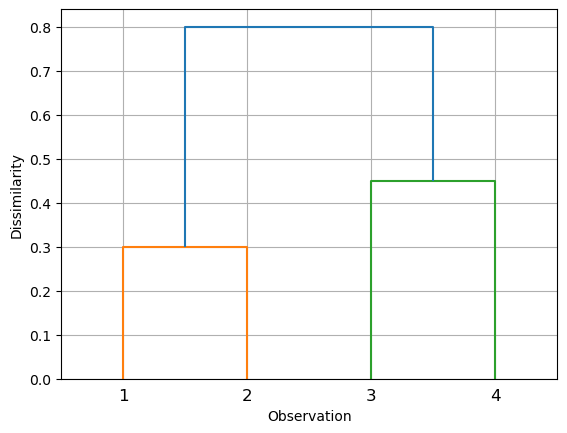

In [315]:
dissimilarity = np.array([0.3, 0.4, 0.7, 0.5, 0.8, 0.45])

Z_dendro = linkage(dissimilarity, method="complete")

plt.figure()
dendrogram(Z_dendro, labels=[1, 2, 3, 4])
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.grid()
plt.show()

(b)

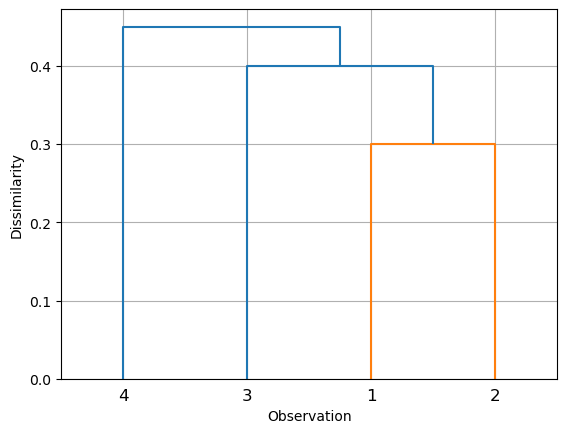

In [316]:
Z_dendro = linkage(dissimilarity, method="single")

plt.figure()
dendrogram(Z_dendro, labels=[1, 2, 3, 4])
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.grid()
plt.show()

(c) cluster1 = (1, 2), cluster2 = (3, 4)

(d) cluster1 = (4), cluster2 = (1, 2, 3)

(e)

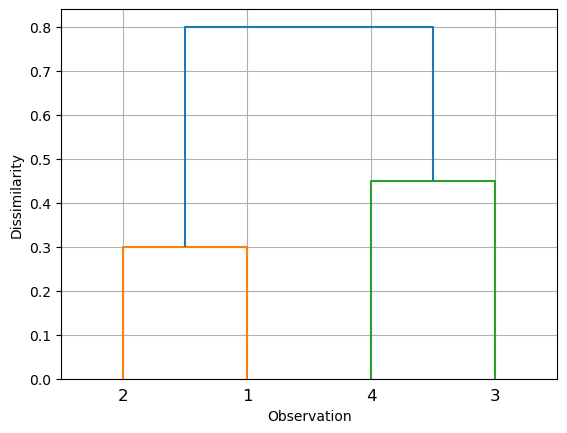

In [3]:
matrix = np.array([
    [0.0, 0.3, 0.4, 0.7],
    [0.3, 0.0, 0.5, 0.8],
    [0.4, 0.5, 0.0, 0.45],
    [0.7, 0.8, 0.45, 0.0],
])

re_sort = [1, 3, 2, 0]   
m_re_sort= matrix[re_sort][:, re_sort]

dissimarity = squareform(m_re_sort)
Z = linkage(dissimarity, method="complete")

plt.figure()
dendrogram(Z, labels=[2, 4, 3, 1])
plt.xlabel("Observation")
plt.ylabel("Dissimilarity")
plt.grid()
plt.show()

### Reference
1. Exact match and hamming score/ loss methods for evaluating multi-label classification: https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd
<br>https://scikit-learn.org/stable/modules/model_evaluation.html#hamming-loss
<br>https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics
2. GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
3. SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
4. LinearSVC:https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
5. Kmeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
6. silhouette score:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
7. linkage: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
8. dendrogram: https://docs.scipy.org/doc//scipy-1.16.2/reference/generated/scipy.cluster.hierarchy.dendrogram.html
